In [1]:
import numpy as np
import time
from PySDM import Formulae
from PySDM.physics.constants import si
from PySDM.backends import CPU
from PySDM_examples.Luettmer_homogeneous_freezing.simulation import Simulation
from PySDM_examples.Luettmer_homogeneous_freezing.settings import Settings
from PySDM_examples.Luettmer_homogeneous_freezing import plot
from importlib import reload
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot


In [2]:
"""  basic setup for homogeneous freezing of pure-liquid droplets """
"""
Ensemble for:
3. n_c
"""

def run_simulations(setting):

        if setting["hom_freezing"] == "threshold":
            setting["number_of_ensemble_runs"] = 1

        simulation = { "settings": setting,
                       "ensemble_member_outputs": [],
                       }

        for n in range(setting["number_of_ensemble_runs"]):
            model_setup = Settings(**simulation["settings"])
            model_setup.formulae.seed += 1
            model = Simulation(model_setup)
            simulation["ensemble_member_outputs"].append( model.run() )

        return simulation


n_sd = 100
number_concentration_droplets = 850 / si.cm**3
mean_radius_dry_aerosol= 15 * si.nanometer
updraft = 1 * si.meter / si.second
initial_temperature =  -30. + 273.
# time_step = 1. * si.second
dz = 1 * si.meter

standard = {  "n_sd": n_sd,
    "w_updraft": updraft,
    "T0":  initial_temperature,
    "dz": dz,
    "N_dv_droplet_distribution": number_concentration_droplets,
    "r_mean_droplet_distribution": mean_radius_dry_aerosol,
    "type_droplet_distribution": "monodisperse",
    "RH_0":0.995,
    "p0": 500 * si.hectopascals,
    "condensation_enable": True,
    "deposition_enable": False,
    "number_of_ensemble_runs": 1,
            }

backends = {
   "threshold": CPU(formulae = Formulae(
        particle_shape_and_density="MixedPhaseSpheres",
        homogeneous_ice_nucleation_rate="Null",
        seed=time.time_ns(),
    )),
    "KoopMurray2016": CPU(formulae = Formulae(
        particle_shape_and_density="MixedPhaseSpheres",
        homogeneous_ice_nucleation_rate="KoopMurray2016",
        seed=time.time_ns(),
    )),
   "Koop_Correction": CPU(formulae = Formulae(
        particle_shape_and_density="MixedPhaseSpheres",
        homogeneous_ice_nucleation_rate="Koop_Correction",
        seed=time.time_ns(),
    )),
    "Koop2000": CPU(formulae = Formulae(
        particle_shape_and_density="MixedPhaseSpheres",
        homogeneous_ice_nucleation_rate="Koop2000",
        seed=time.time_ns(),
    )),
}
hom_freezing_types = backends.keys()

simulations = []

In [3]:
""" Simulations for n_sd ensemble """
number_of_nsd = (10, 100, 1000)
for hom_freezing_type in backends.keys():
    for n_sd in number_of_nsd:
        setting_dict = {
            **standard,
            "n_sd": n_sd,
            "backend": backends[hom_freezing_type],
            "hom_freezing": hom_freezing_type,
            "number_of_ensemble_runs": 5,
            }

        simulations.append( run_simulations(setting_dict) )

Setting up simulation for threshold with wpdraft=1.0 and n_sd=10
Starting simulation...
all particles frozen
Setting up simulation for threshold with wpdraft=1.0 and n_sd=100
Starting simulation...
all particles frozen
Setting up simulation for threshold with wpdraft=1.0 and n_sd=1000
Starting simulation...
all particles frozen
Setting up simulation for KoopMurray2016 with wpdraft=1.0 and n_sd=10
Starting simulation...
all particles frozen
Setting up simulation for KoopMurray2016 with wpdraft=1.0 and n_sd=10
Starting simulation...
all particles frozen
Setting up simulation for KoopMurray2016 with wpdraft=1.0 and n_sd=10
Starting simulation...
all particles frozen
Setting up simulation for KoopMurray2016 with wpdraft=1.0 and n_sd=10
Starting simulation...
all particles frozen
Setting up simulation for KoopMurray2016 with wpdraft=1.0 and n_sd=10
Starting simulation...
all particles frozen
Setting up simulation for KoopMurray2016 with wpdraft=1.0 and n_sd=100
Starting simulation...
all pa

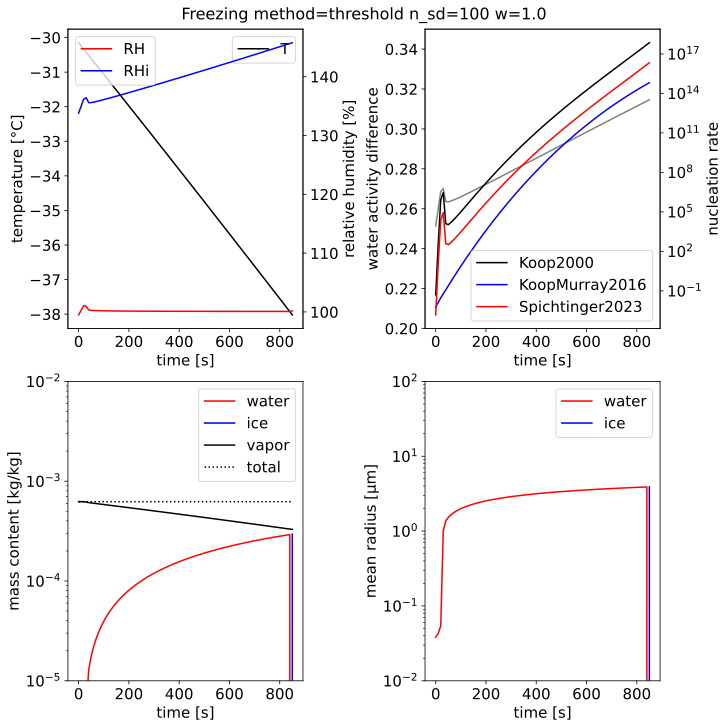

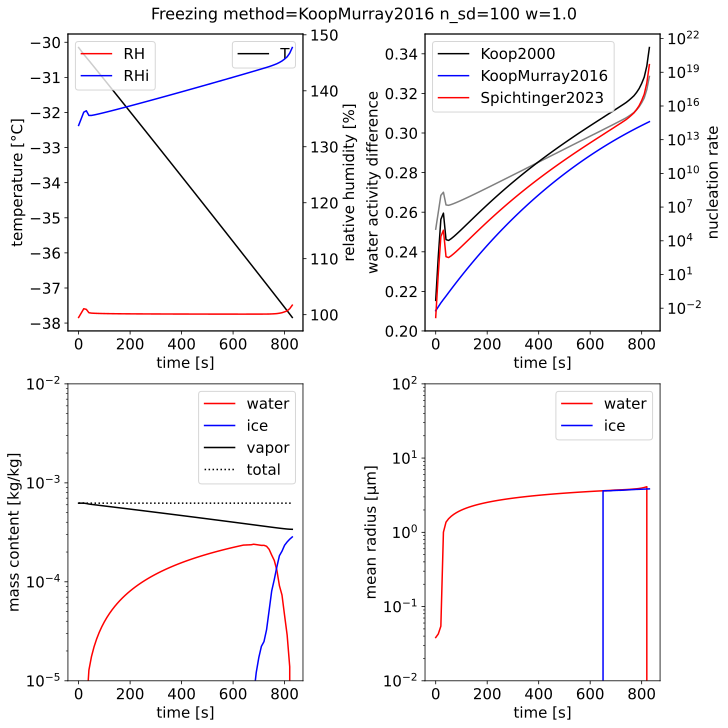

In [4]:
plot.plot_thermodynamics_and_bulk(simulations[1])
show_plot()
plot.plot_thermodynamics_and_bulk(simulations[4])
show_plot()

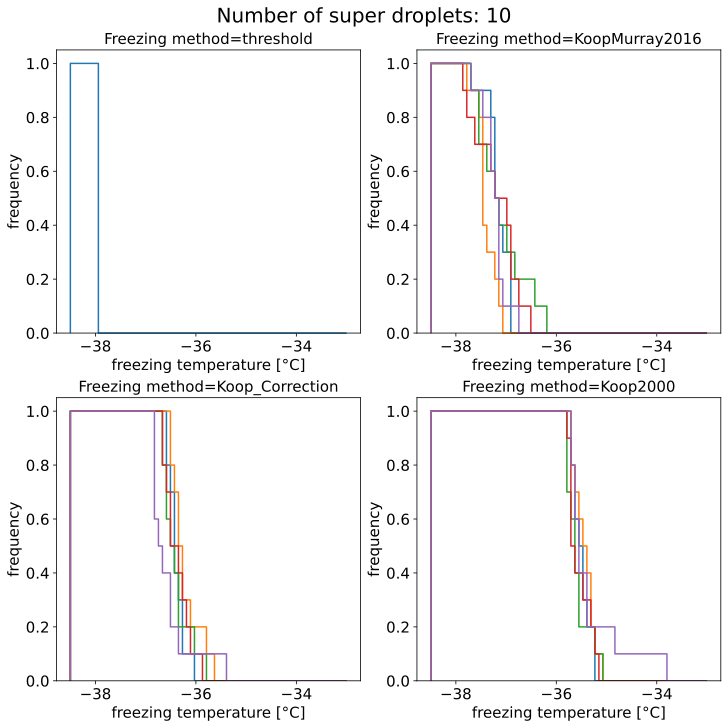

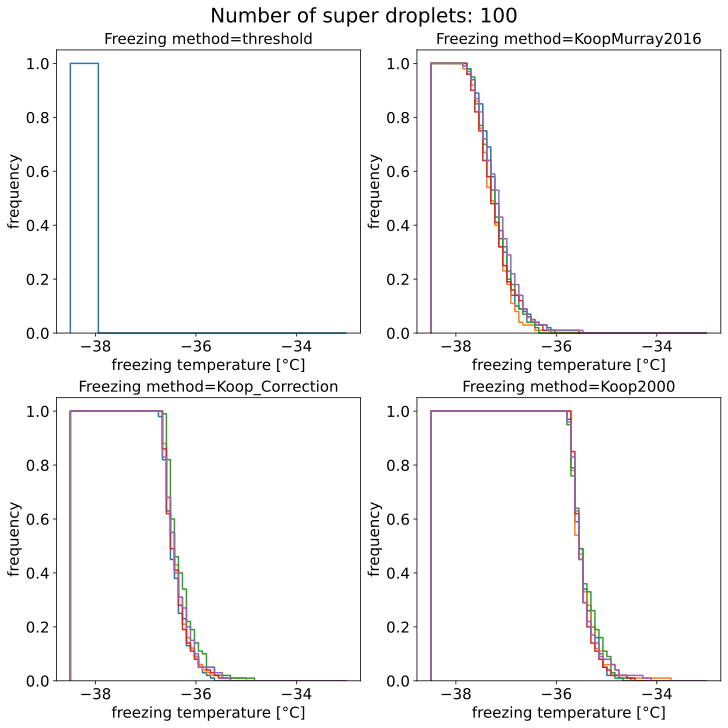

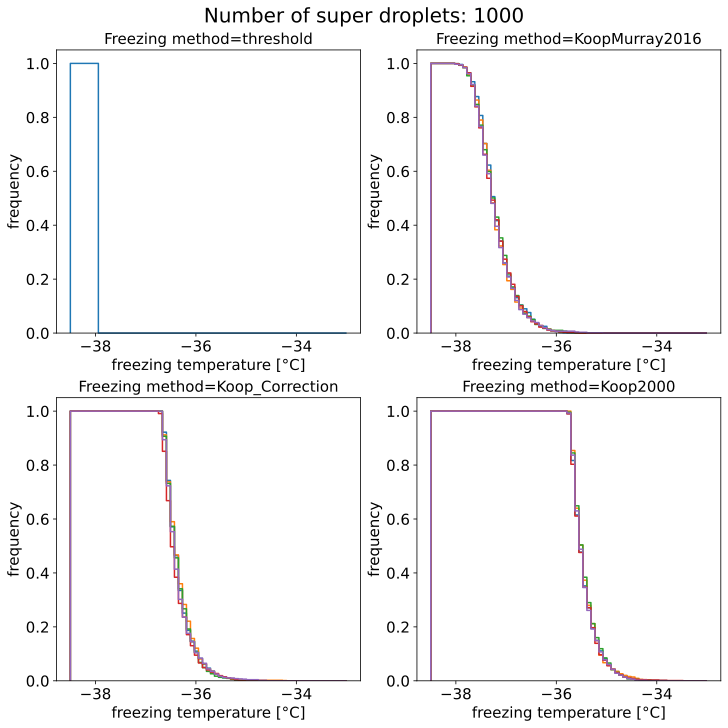

In [86]:
for n_sd in number_of_nsd:
    fig, axs = pyplot.subplots(2, 2, figsize=(10, 10), constrained_layout=True)
    fig.suptitle("Number of super droplets: {}".format(n_sd),fontsize=20)
    axs = axs.ravel()
    i = 0
    for simulation in simulations:
        if simulation["settings"]["n_sd"] == n_sd and simulation["settings"]["w_updraft"] == standard["w_updraft"]:
            axs[i] = plot.plot_freezing_temperatures_histogram(axs[i], simulation)
            i += 1
    show_plot()

In [41]:
""" Simulations for updraft histogram  """

vertical_updrafts = (  0.1 * si.meter / si.second,
                       0.5 * si.meter / si.second,
                       1. * si.meter / si.second,
                       5. * si.meter / si.second,
                       10. * si.meter / si.second   )

for hom_freezing_type in backends.keys():
    for updraft in vertical_updrafts:
        if updraft == standard["w_updraft"]:
            continue
        setting_dict = {
            **standard,
            "w_updraft": updraft,
            "backend": backends[hom_freezing_type],
            "hom_freezing": hom_freezing_type,
            "number_of_ensemble_runs": 1,
            }

        simulations.append( run_simulations(setting_dict) )

Setting up simulation for threshold with wpdraft=0.1 and n_sd=100


KeyboardInterrupt: 

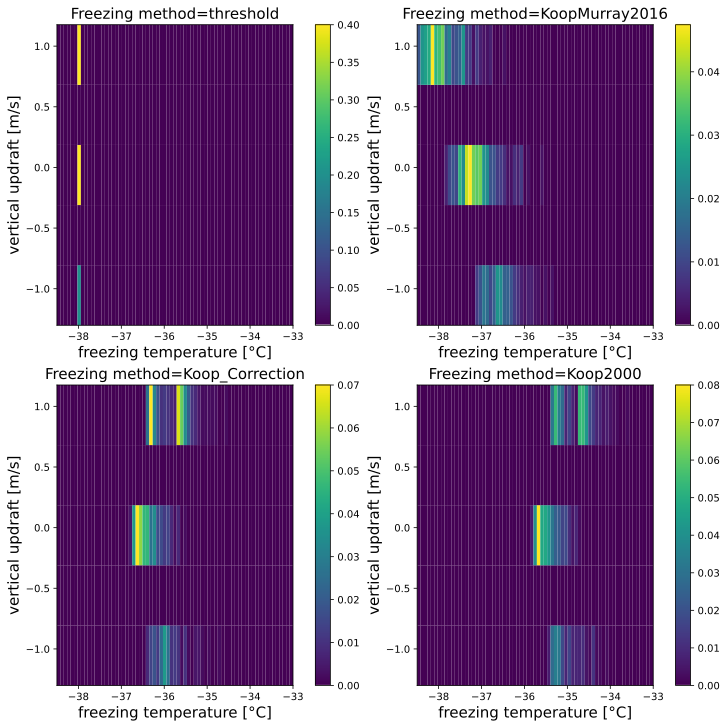

In [95]:
histogram_data_dict = {}

for hom_freezing_type in hom_freezing_types:

    sub_dict = {}
    histogram_data_dict[hom_freezing_type] = sub_dict

    sub_dict["T_frz_histogram_list"] = []
    sub_dict["w_updraft_histogram_list"] = []

    for updraft in vertical_updrafts:
        for simulation in simulations:
            if (simulation["settings"]["n_sd"] == standard["n_sd"]
                    and simulation["settings"]["w_updraft"] == updraft
                    and simulation["settings"]["hom_freezing"] == hom_freezing_type):
                output = simulation["ensemble_member_outputs"][0]
                T_frz = output["T_frz"][-1]
                sub_dict["T_frz_histogram_list"].extend( T_frz )
                sub_dict["w_updraft_histogram_list"].extend( np.full_like(T_frz, updraft) )

plot.plot_freezing_temperatures_2d_histogram(histogram_data_dict)